In [1]:
import sys
sys.path.append("FinRL-Library")

In [2]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow','numpy','pandas',
            'scikit-learn','stable-baselines3[extra]','ray[default]','ray[tune]','lz4','tensorboardX','gputil',
            'trading_calendars','alpaca_trade_api','ccxt','jqdatasdk','wrds','pytest','setuptools','wheel','dm_tree','pyfolio'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4
    !pip install numpy

    !pip install stockstats
    !pip install yfinance

    # plot
    !pip install matplotlib

    # Model Building Requirements
    !pip install scikit-learn
    !pip install gym
    !pip install stable-baselines3[extra]
    !pip install ray[default]
    !pip install ray[tune]
    !pip install lz4
    !pip install tensorboardX==1.15.0
    !pip install gputil

    # market data & paper trading API
    !pip install trading_calendars
    !pip install alpaca_trade_api
    !pip install ccxt
    !pip install jqdatasdk
    !pip install wrds

    # testing requirements
    !pip install pytest

    # packaging
    !pip install setuptools
    !pip install wheel
    
    !pip install git+https://github.com/quantopian/pyfolio.git
    !pip install dm_tree


ERROR: Could not find a version that satisfies the requirement tensorflow==1.15.4 (from versions: 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0)
ERROR: No matching distribution found for tensorflow==1.15.4


ERROR: Could not find a version that satisfies the requirement tensorboardX==1.15.0 (from versions: 0.6.9, 0.8, 1.0, 1.1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4)
ERROR: No matching distribution found for tensorboardX==1.15.0


  Cloning https://github.com/quantopian/pyfolio.git to c:\users\arjunsingh\appdata\local\temp\pip-req-build-92apcn88
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=76264 sha256=da833eb525ea443e5b410e042697552c320b2f8fde63239f8d76d059b51167e1
  Stored in directory: C:\Users\ArjunSingh\AppData\Local\Temp\pip-ephem-wheel-cache-mhfwk3rn\wheels\7b\59\8b\3c276a18b58c04a1fd0e1351e979fb5396f93fbde5b5438df1
Successfully built pyfolio


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import gym
from gym import spaces
from gym.utils import seeding
from copy import deepcopy
import pickle

matplotlib.use("Agg")

from torch.nn import Softsign, ReLU
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common import logger

import multiprocessing

from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.neo_finrl.env_stock_trading.env_stocktrading_np import StockTradingEnv as StockTradingEnv_numpy
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.drl_agents.rllib.models import DRLAgent as DRLAgent_rllib
from finrl.neo_finrl.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [5]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-08-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()
df.sort_values(['date','tic'],ignore_index=True).head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.782837,746015200,AAPL,4
1,2009-01-02,18.570000,19.520000,18.400000,15.657365,10955700,AXP,4
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
3,2009-01-02,44.910000,46.980000,44.709999,32.655109,7117200,CAT,4
4,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4


In [6]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [7]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.782837,746015200,AAPL,4,0.0,100.0,66.666667,100.0,0.0
1,2009-01-02,18.570000,19.520000,18.400000,15.657365,10955700,AXP,4,0.0,100.0,66.666667,100.0,0.0
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,0.0,100.0,66.666667,100.0,0.0
3,2009-01-02,44.910000,46.980000,44.709999,32.655109,7117200,CAT,4,0.0,100.0,66.666667,100.0,0.0
4,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4,0.0,100.0,66.666667,100.0,0.0


In [8]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2021-06-01')
print(len(train))
print(len(trade))

75480
18210


In [9]:
class StockTradingEnvV2(gym.Env):
    
    """
    A stock trading environment for OpenAI gym
    Parameters:
    state space: {start_cash, <owned_shares>, for s in stocks{<stock.values>}, }
        df (pandas.DataFrame): Dataframe containing data
        transaction_cost (float): cost for buying or selling shares
        hmax (int): max number of share purchases allowed per asset
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        reward_scaling (float): Scaling value to multiply reward by at each step. 
        initial_amount: (int, float): Amount of cash initially available
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe. 
        out_of_cash_penalty (int, float): Penalty to apply if the algorithm runs out of cash
    


    tests:
        after reset, static strategy should result in same metrics

        buy zero should result in no costs, no assets purchased
        given no change in prices, no change in asset values
    """
    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        transaction_cost_pct=3e-3,
        date_col_name="date",
        hmax=10,
        turbulence_threshold=None,
        print_verbosity=10,
        reward_scaling=1e-4,
        initial_amount=1e6,
        daily_information_cols=["open", "close", "high", "low", "volume"],
        out_of_cash_penalty=None,
        cache_indicator_data = True
    ):
        self.df = df
        self.stock_col = "tic"
        self.assets = df[self.stock_col].unique()
        self.dates = df[date_col_name].sort_values().unique()
        self.df = self.df.set_index(date_col_name)
        self.hmax = hmax
        self.initial_amount = initial_amount
        if out_of_cash_penalty is None:
            out_of_cash_penalty=-initial_amount*0.5
        self.out_of_cash_penalty = out_of_cash_penalty
        self.print_verbosity = print_verbosity
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.daily_information_cols = daily_information_cols
        self.close_index = self.daily_information_cols.index("close")
        self.state_space = (
            1 + len(self.assets) + len(self.assets) * len(self.daily_information_cols)
        )
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.assets),))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.episode = -1  # initialize so we can call reset
        self.seed()
        self.episode_history = []
        self.printed_header = False
        self.cache_indicator_data = cache_indicator_data
        self.cached_data = None
        if self.cache_indicator_data:
            print("caching data")
            self.cached_data = [self.get_date_vector(i) for i, _ in enumerate(self.dates)]
            print("data cached!")
        

    def seed(self):
        pass


    def reset(self):
        self.sum_trades = 0
        self.date_index = 0
        self.episode += 1
        self.actions_memory = []
        self.state_memory = []
        self.account_information = {
            "cash": [],
            "asset_value": [],
            "total_assets": [],
            'reward': []
        }
        self.state_memory.append(
            np.array(
                [self.initial_amount]
                + [0] * len(self.assets)
                + self.get_date_vector(self.date_index)
            )
        )
        return [0 for _ in range(self.state_space)]

    def get_date_vector(self, date, cols=None):
        if (cols is None) and (self.cached_data is not None):
            return self.cached_data[date]
        else:
            date = self.dates[date]
            if cols is None:
                cols = self.daily_information_cols
            trunc_df = self.df.loc[date]
            v = []
            for a in self.assets:
                subset = trunc_df[trunc_df[self.stock_col] == a]
                v += subset.loc[date, cols].tolist()
            assert len(v) == len(self.assets) * len(cols)
            return v
    
    def log_step(self, reason, terminal_reward=None):
        if terminal_reward is None:
            terminal_reward = self.account_information['reward'][-1]
        cash_pct = self.account_information['cash'][-1]/self.account_information['total_assets'][-1]
        rec = [self.episode, self.date_index, reason, f"${int(self.account_information['total_assets'][-1])}",f"${terminal_reward:0.2f}", f"{cash_pct*100:0.2f}%"]

        self.episode_history.append(rec)
        print(self.template.format(*rec))

    def step(self, actions):
        #print header only first time
        if self.printed_header is False:
            self.template = "{0:8}|{1:10}|{2:15}|{3:7}|{4:10}|{5:10}" # column widths: 8, 10, 15, 7, 10
            print(self.template.format("EPISODE", "STEPS", "TERMINAL_REASON", "TOT_ASSETS", "TERMINAL_REWARD_unsc", "CASH_PCT"))
            self.printed_header = True

        # define terminal function in scope so we can do something about the cycle being over
        def return_terminal(reason='Last Date', extra_reward=0):

            state = self.state_memory[-1]
            reward = 0
            reward += extra_reward
            self.log_step(reason = reason, terminal_reward= reward)
            reward = reward*self.reward_scaling
            # Add outputs to logger interface
            reward_pct = self.account_information['total_assets'][-1]/self.initial_amount
            '''logger.record("environment/total_reward_pct", (reward_pct-1)*100)
            logger.record("environment/daily_trades", self.sum_trades/self.date_index)
            logger.record("environment/completed_steps", self.date_index)
            logger.record("environment/sum_rewards", np.sum(self.account_information['reward']))'''
            return state, reward, True, {}

        # print if it's time.
        if (self.date_index + 1) % self.print_verbosity == 0:
            self.log_step(reason = 'update')

        #if we're at the end
        if self.date_index == len(self.dates) - 1:
            #if we hit the end, set reward to total gains (or losses)
            terminal_reward = self.account_information['total_assets'][-1]-self.initial_amount
            return return_terminal(extra_reward = terminal_reward)
        else:
            begin_cash = self.state_memory[-1][0]
            holdings = self.state_memory[-1][1 : len(self.assets) + 1]
            assert (min(holdings)>=0)
            closings = np.array(self.get_date_vector(self.date_index, cols=["close"]))

            # compute current value of holdings
            asset_value = np.dot(holdings, closings)

            # reward is (cash + assets) - (cash_last_step + assets_last_step)
            if self.date_index==0:
                reward = 0
            else:
                reward = (
                    begin_cash + asset_value - self.account_information["total_assets"][-1]
                )

            # log the values of cash, assets, and total assets
            self.account_information["cash"].append(begin_cash)
            self.account_information["asset_value"].append(asset_value)
            self.account_information["total_assets"].append(begin_cash + asset_value)
            self.account_information['reward'].append(reward)

            # multiply action values by our scalar multiplier and save
            actions = actions * self.hmax
            self.actions_memory.append(actions)

            # clip actions so we can't sell more assets than we hold
            actions = np.maximum(actions, -np.array(holdings))
            self.sum_trades += np.sum(np.abs(actions))

            # compute our proceeds from sales, and add to cash
            sells = -np.clip(actions, -np.inf, 0)
            proceeds = np.dot(sells, closings)
            costs = proceeds * self.transaction_cost_pct
            coh = begin_cash + proceeds

            # compute the cost of our buys
            buys = np.clip(actions, 0, np.inf)
            spend = np.dot(buys, closings)
            costs += spend * self.transaction_cost_pct

            # if we run out of cash, end the cycle and penalize
            if (spend + costs) > coh:
                return return_terminal(reason = 'CASH SHORTAGE',
                    extra_reward=self.out_of_cash_penalty,
                )

            # verify we didn't do anything impossible here
            assert (spend + costs) <= coh

            # update our holdings
            coh = coh - spend - costs
            holdings_updated = holdings + actions
            self.date_index += 1
            state = (
                [coh] + list(holdings_updated) + self.get_date_vector(self.date_index)
            )
            self.state_memory.append(state)
            reward = reward * self.reward_scaling
            return state, reward, False, {}

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
    
    def get_multiproc_env(self, n = 10):
        def get_self():
            return deepcopy(self)
        e = SubprocVecEnv([get_self for _ in range(n)], start_method = 'fork')
        obs = e.reset()
        return e, obs

    def save_asset_memory(self):
        self.account_information["date"] = self.dates[: len(self.account_information['cash'])]
        return pd.DataFrame(self.account_information)

    def save_action_memory(self):
        return pd.DataFrame(
            {"date": self.dates[: self.date_index], "actions": self.actions_memory}
        )

In [10]:
information_cols = ['open', 'high', 'low', 'close', 'volume', 'day', 'macd', 'rsi_30', 'cci_30', 'dx_30', 'turbulence']

e_train_gym = StockTradingEnvV2(df = train, 
                              hmax = 100, 
                              out_of_cash_penalty=-1e6,
                              daily_information_cols = information_cols,
                              print_verbosity = 500)

caching data
data cached!


In [11]:
# let's do multiprocessing with n_cores-1
n_cores = multiprocessing.cpu_count() - 2
print(f"using {n_cores} cores")


# env_train, _ = e_train_gym.get_multiproc_env(n = n_cores)
env_train, _ = e_train_gym.get_sb_env()

using 6 cores


In [12]:
agent = DRLAgent(env = env_train)
print(config.PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}


In [13]:
ppo_params ={'n_steps': 128, 
             'ent_coef': 0.01, 
             'learning_rate': 0.00025, 
             'batch_size': 256, 
            'gamma': 0.99}

policy_kwargs = {
#     "activation_fn": ReLU,
    "net_arch": [1024, 1024, 1024], 
#     "squash_output": True
}

model = agent.get_model("ppo",  model_kwargs = ppo_params, policy_kwargs = policy_kwargs, verbose = 0)
model = model.load("quicksave_ppo_dow.model")

{'n_steps': 128, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 256, 'gamma': 0.99}


C:\ProgramData\Anaconda3\lib\site-packages\stable_baselines3\ppo\ppo.py:137: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 128`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 128
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=128 and n_envs=1)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


AttributeError: 'Box' object has no attribute '_shape'

In [14]:
data_turbulence = processed[(processed.date<'2019-01-01') & (processed.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [15]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       33.278199
std        33.999917
min         0.000000
25%        15.233738
50%        25.166800
75%        39.290097
max       332.848643
Name: turbulence, dtype: float64

In [16]:
def DRL_prediction(model, environment):
    test_env, test_obs = environment.get_sb_env()
    """make a prediction"""
    account_memory = []
    actions_memory = []
    test_env.reset()
    for i in range(len(environment.df.index.unique())):
        action, _states = model.predict(test_obs)
        #account_memory = test_env.env_method(method_name="save_asset_memory")
        #actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        if not dones[0]:
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
        if dones[0]:
            print("hit end!")
            break
    return account_memory[0], actions_memory[0]

In [17]:
trade = data_split(processed, '2020-01-01','2021-06-01')
e_trade_gym = StockTradingEnvV2(df = trade,hmax = 20,initial_amount = 1000000,
                              daily_information_cols = information_cols,
                              print_verbosity = 500)

df_account_value, df_actions = DRL_prediction(model=model,
                        environment = e_trade_gym,)

caching data
data cached!
EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  
       1|       354|Last Date      |$1165993|$165993.33|13.53%    
hit end!


In [18]:
df_account_value.head(50)

,cash,asset_value,total_assets,reward,date
0,1000000.000000,0.000000,1.000000e+06,0.000000,2020-01-02
1,974750.246947,24977.202558,9.997274e+05,-272.550495,2020-01-03
2,958352.816621,41361.336148,9.997142e+05,-13.296736,2020-01-06
3,938822.817996,60547.157011,9.993700e+05,-344.177762,2020-01-07
4,922400.384117,77563.350747,9.999637e+05,593.759856,2020-01-08
5,920212.824713,80236.062509,1.000449e+06,485.152358,2020-01-09
6,923609.389823,76441.270505,1.000051e+06,-398.226894,2020-01-10
7,921392.217984,78981.795168,1.000374e+06,323.352824,2020-01-13
8,913492.876840,86821.994386,1.000315e+06,-59.141925,2020-01-14
9,918272.284854,82408.130151,1.000680e+06,365.543779,2020-01-15


In [19]:
df_actions.to_dict(orient = 'rows')[:3]

C:\Users\ArjunSingh\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


[{'date': '2020-01-02',
  'actions': array([ 18.705719 , -11.145237 ,  13.196486 ,  20.       ,  -9.733311 ,
         -10.347719 ,  -5.3996606,  19.57615  ,   7.714878 ,  -8.77327  ,
          15.796653 ,  -6.742852 , -20.       , -19.021057 , -11.299497 ,
         -20.       ,  20.       , -14.082924 ,  -4.0867314,   2.1948764,
         -19.605518 ,  10.705408 ,  11.679679 , -10.590161 , -17.024418 ,
          20.       , -14.121845 ,   3.560892 , -16.628885 , -20.       ],
        dtype=float32)},
 {'date': '2020-01-03',
  'actions': array([ 14.004411 ,  -2.1348546, -15.294328 , -20.       ,  -8.769304 ,
         -10.518394 ,  -7.8376155,   5.043323 ,  20.       ,  20.       ,
          20.       , -20.       , -13.055906 ,   6.981835 ,  -3.9723995,
           0.9204732, -20.       ,  20.       ,  20.       , -20.       ,
          20.       ,  11.905869 ,  -8.449527 , -20.       ,  14.186092 ,
          16.918316 , -18.334118 , -20.       , -20.       ,  -3.7061362],
        dtype=f

In [20]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value, value_col_name = 'total_assets')
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.115523
Cumulative returns     0.165993
Annual volatility      0.104647
Sharpe ratio           1.100149
Calmar ratio           1.162822
Stability              0.757813
Max drawdown          -0.099347
Omega ratio            1.213127
Sortino ratio          1.557587
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.972686
Daily value at risk   -0.012727
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (353, 8)


Start date,2020-01-02
End date,2021-05-26
Total months,16
,Backtest
Annual return,11.393%
Cumulative returns,16.316%
Annual volatility,10.478%
Sharpe ratio,1.09
Calmar ratio,1.15
Stability,0.76
Max drawdown,-9.935%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.93,2020-02-12,2020-03-23,2020-08-12,131
1,4.80,2020-09-02,2020-10-28,2020-11-10,50
2,3.03,2021-05-07,2021-05-12,NaT,NaN
3,2.85,2021-01-12,2021-01-29,2021-02-09,21
4,2.24,2021-02-24,2021-02-26,2021-03-08,9


C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\tears.py:906: UserWarning: Passed returns do not overlap with anyinteresting times.
  warnings.warn('Passed returns do not overlap with any'


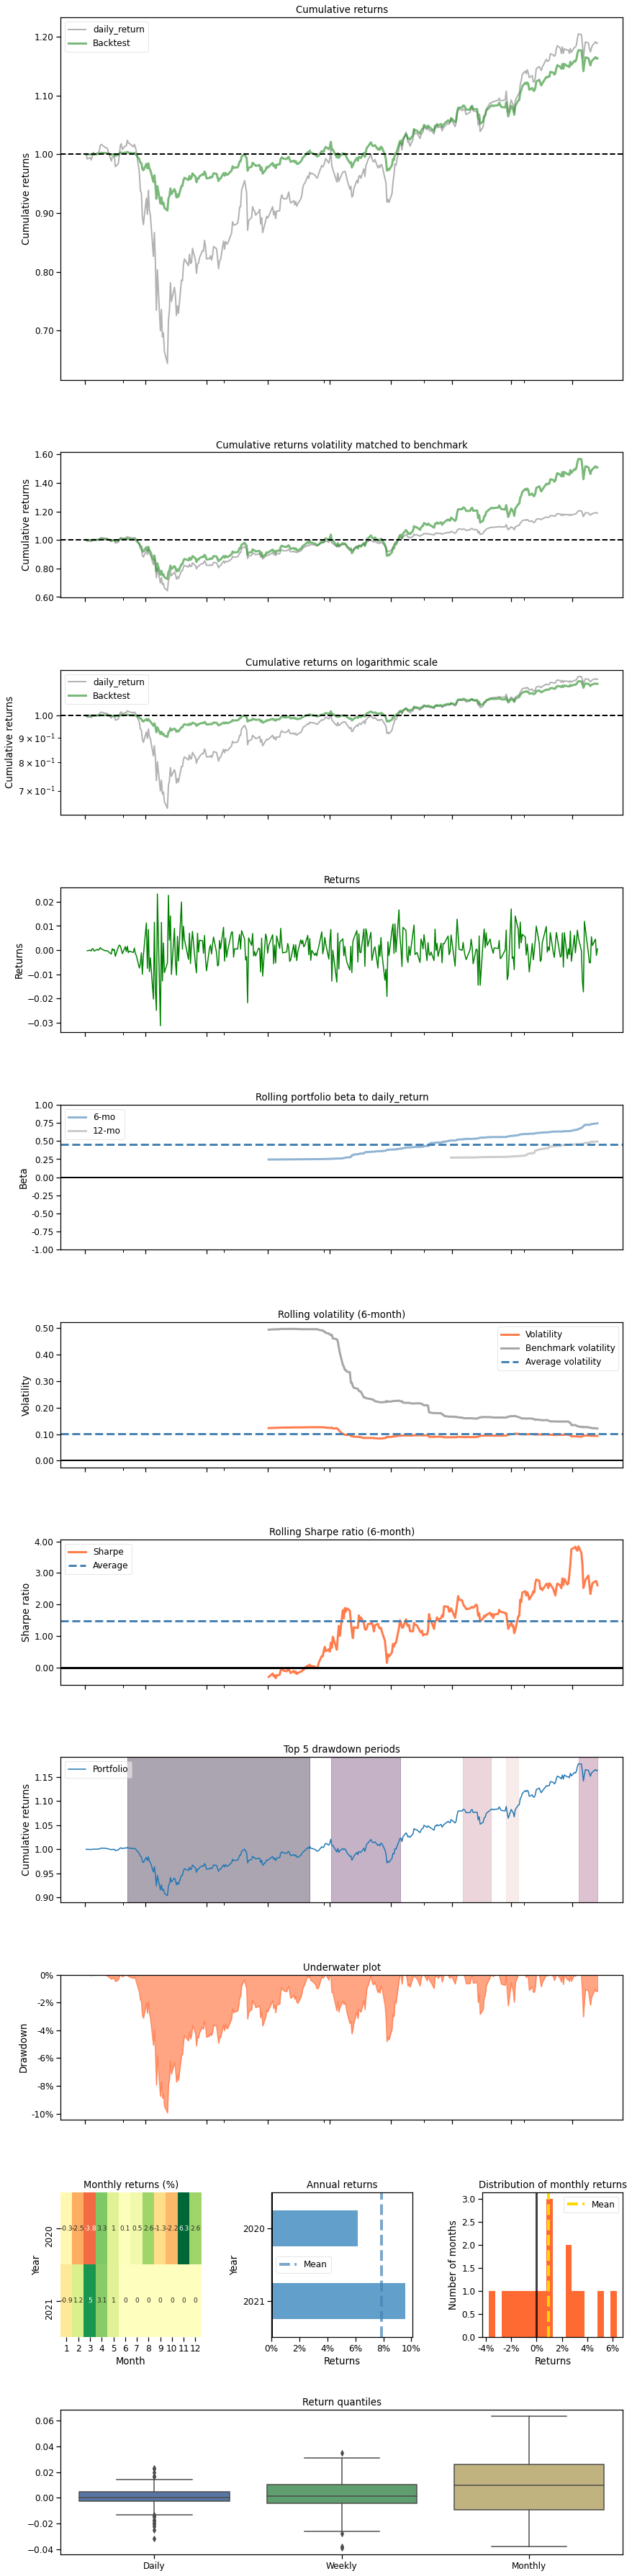

In [30]:
print("==============Compare to DJIA===========")

%matplotlib inline
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.date.values[0],
             baseline_end = df_account_value.date.values[-1], value_col_name = 'total_assets')